In [87]:
import cv2
import numpy as np
import os
import csv
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [4]:
def segment(image , threshold):
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresholded_image = cv2.threshold(grayscale_image, threshold, 255, cv2.THRESH_BINARY)
    return thresholded_image

In [5]:
def detect_edges(image, threshold1=100, threshold2=200):
  edges = cv2.Canny(image, threshold1, threshold2)
  return edges

In [6]:
def calculate_eccentricity(height, width):
  if width == 0:
    return 1.0
  else:
    return height / width

In [7]:
def calculate_elongation(eccentricity):
    elongation = 1 - eccentricity
    return elongation

In [8]:
def calculate_surface_area(width, height):
    surface_area = np.pi * width * height / 4
    return surface_area

In [9]:

def estimate_surface_area(height_pixels, width_pixels, scale_factor):
    # For example, 1 pixel corresponds to 0.01 millimeters
    height_mm = height_pixels * scale_factor
    width_mm = width_pixels * scale_factor

    surface_area = np.pi * height_mm * width_mm / 4
    return surface_area


In [19]:
def calculate_circularity(area, perimeter):
    return  area / (perimeter**2)


In [11]:
def calculate_D(surface_area):
    D = np.sqrt(4 * surface_area / np.pi)
    return D

In [12]:
def calculate_form_factor(surface_area, perimeter):
        form_factor = 4 * np.pi * surface_area / (perimeter ** 2)
        return form_factor


In [42]:
def calculate_convexity(convex_perimeter, original_perimeter):
    convexity = convex_perimeter / original_perimeter
    return convexity


In [47]:
def calculate_irregularity_ratio(area, convex_hull_area):
  if convex_hull_area == 0:
    return 0.0  
  else:
    return area / convex_hull_area

In [68]:
import cv2
import numpy as np

def calculate_moments(image):
 
  image = image.astype(np.float32)
  height, width = image.shape
  total_pixels = height * width
  mean = np.sum(image) / total_pixels
  central_moment = np.sum((image - mean) ** 2) / total_pixels
  standard_deviation = np.sqrt(central_moment)

  return mean, central_moment, standard_deviation


In [83]:

def max_line(gx, gy, all_x, all_y) :
  distances = np.sqrt((all_y - gy) ** 2 + (all_x - gx) ** 2)
  return np.max(distances)

In [109]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def process_images(directory, threshold):
    """
    Processes images in a directory, performs segmentation, edge detection,
    calculates center of gravity, maximum radius, height, and width.

    Args:
        directory (str): Path to the directory containing images.
        threshold (int): Threshold for segmentation.

    Returns:
        pandas.DataFrame: DataFrame containing measurements for each image.
    """
    measurements = []

    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            filepath = os.path.join(directory, filename)

            try:
                image = cv2.imread(filepath)
                if image is None:
                    print(f"Error: Could not read image {filepath}")
                    continue 

                Step1_images = segment(image, threshold)  
                edges = detect_edges(Step1_images, 100, 200)  
                result = cv2.bitwise_and(Step1_images, Step1_images, mask=edges)
                white_pixels = np.where(result == 255)
                yy, xx = white_pixels
                gx, gy = np.mean(xx), np.mean(yy)
                max_radius = max_line(gx, gy, xx, yy)  
                height = np.max(yy) - np.min(yy)
                width = np.max(xx) - np.min(xx)
                perimeter = np.count_nonzero(edges)
                
                cv2.circle(result, (int(gx), int(gy)), 5, (255, 0, 0), 2)
                cv2.circle(result, (int(gx), int(gy)), 20, (255, 0, 0), 2)
                max_radius = max_line(gx, gy, xx, yy)
                cv2.circle(result, (int(gx), int(gy)), int(max_radius), (255, 0, 0), 2)

                
                mean, central_moment, standard_deviation = calculate_moments(result)
                eccentricity = calculate_eccentricity(height, width)
                elongation = calculate_elongation(eccentricity)
                surface = calculate_surface_area(width, height)
                surface_e = estimate_surface_area(width, height, 0.01)
                circularity = calculate_circularity(surface, perimeter)
                D = calculate_D(surface)
                form_factor = calculate_form_factor(surface, perimeter)
                
                # Append measurements to the list
                measurements.append([ mean, central_moment,standard_deviation, max_radius,
                                      eccentricity, elongation, surface, surface_e,
                                      circularity, D, form_factor])
                
                plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
                plt.axis('off')
                plt.show()

            except Exception as e:
                print(f"Error processing {filepath}: {e}")
 
    columns = [ "Mean","centralmoment","standard_derivation", "Maximum Radius", "Eccentricity", "Elongation",
               "Surface", "Estimated surface", "Circularity", "D", "Form factor"]
    df = pd.DataFrame(measurements, columns=columns)

    return df


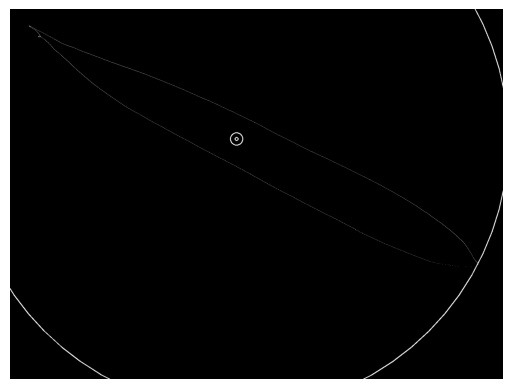

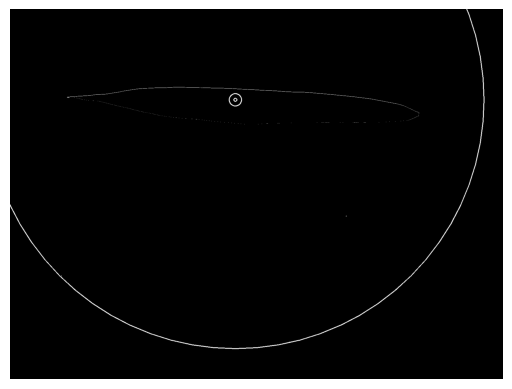

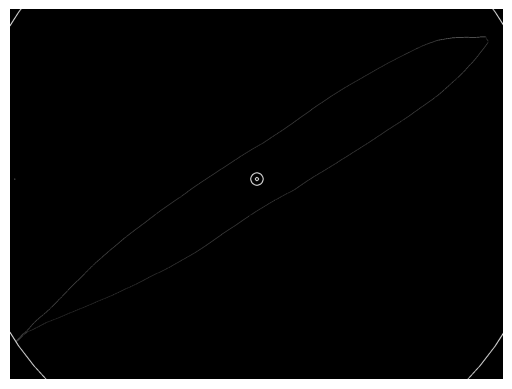

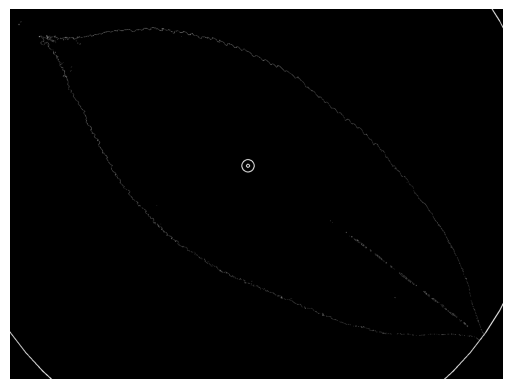

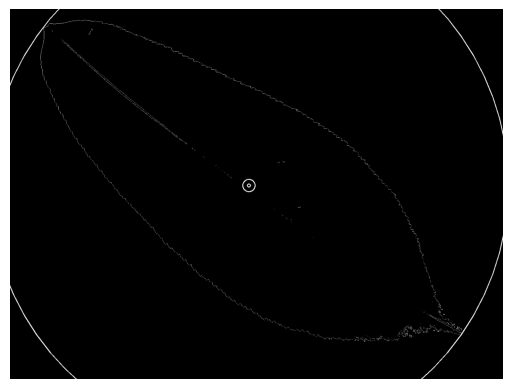

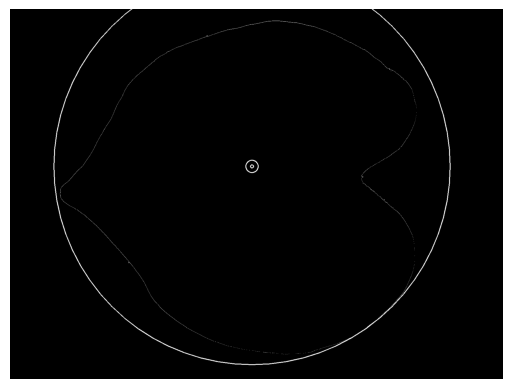

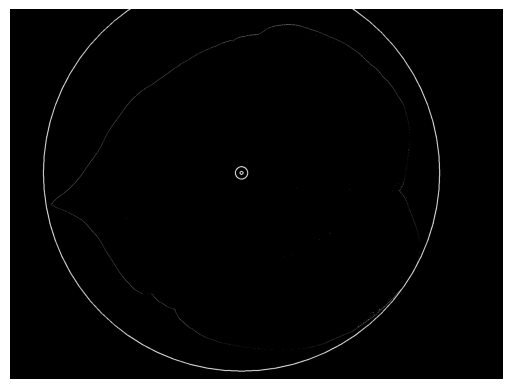

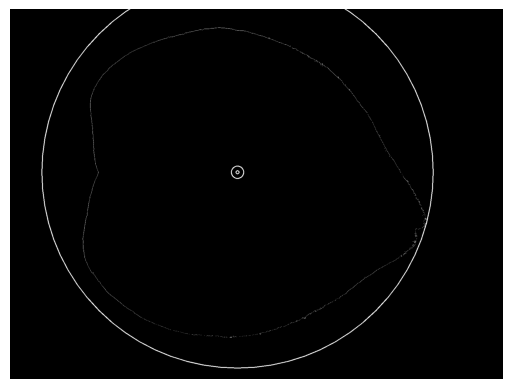

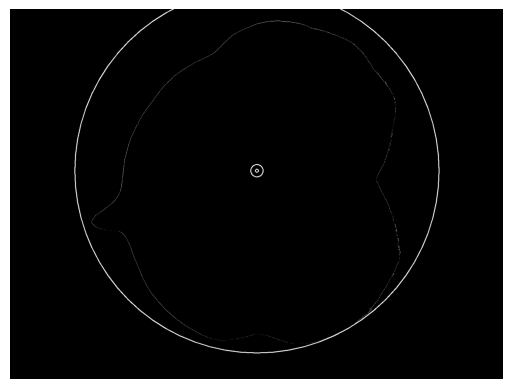

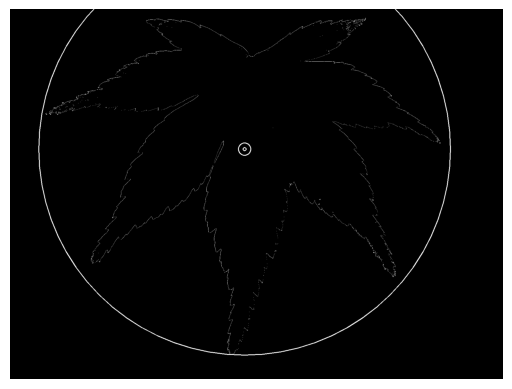

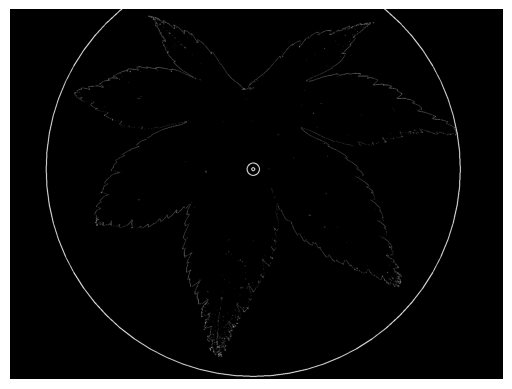

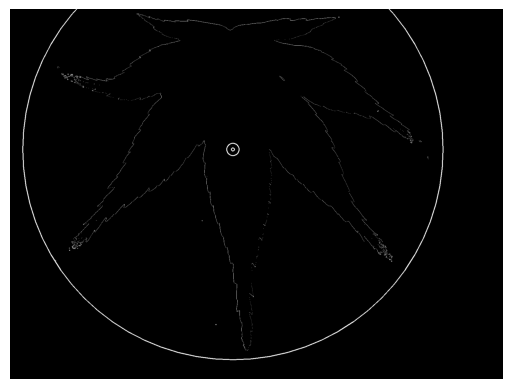

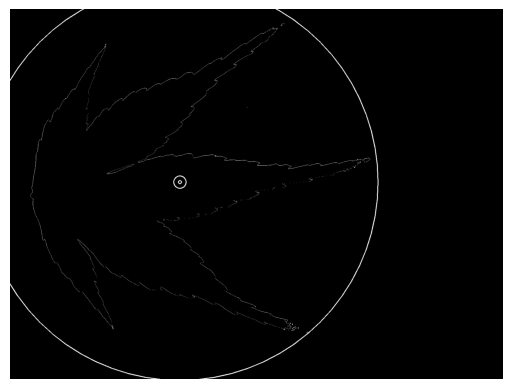

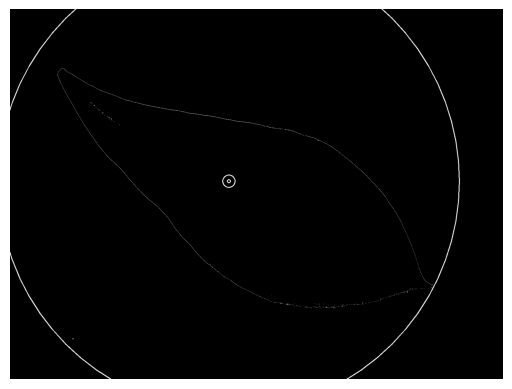

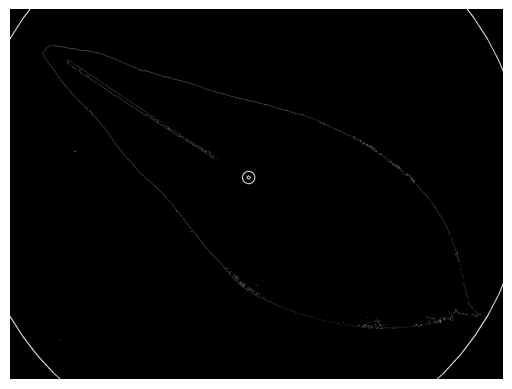

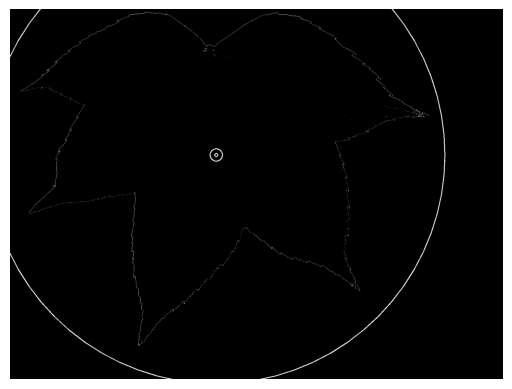

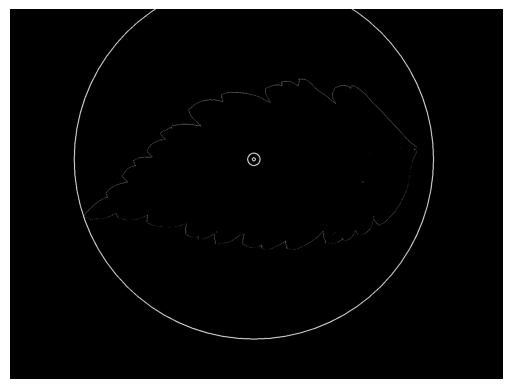

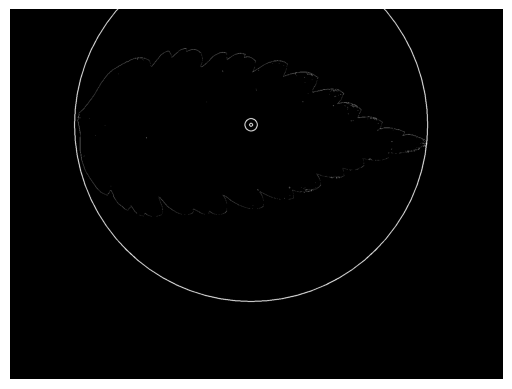

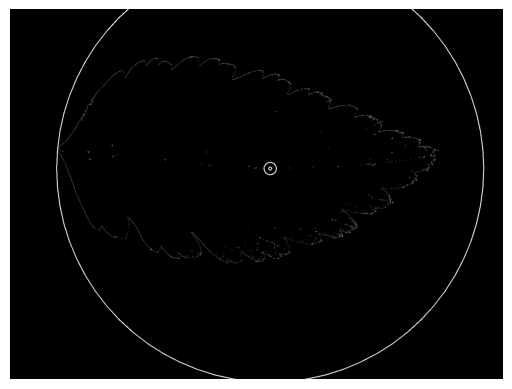

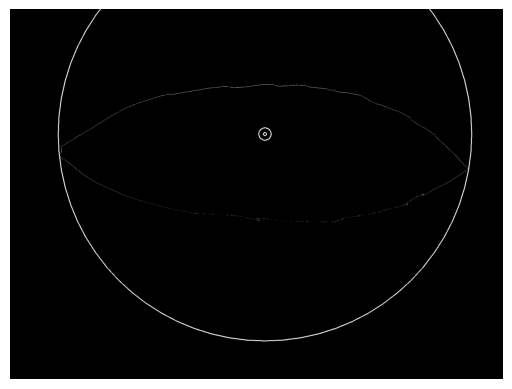

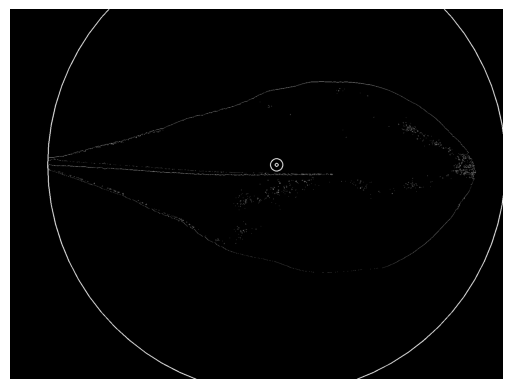

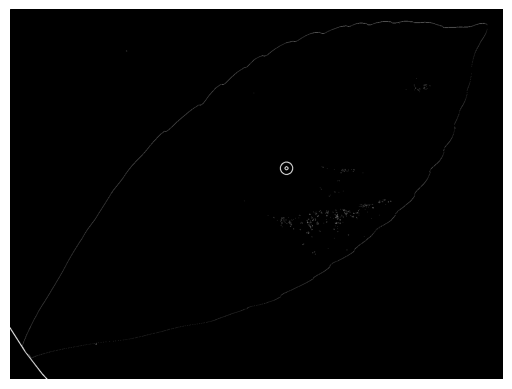

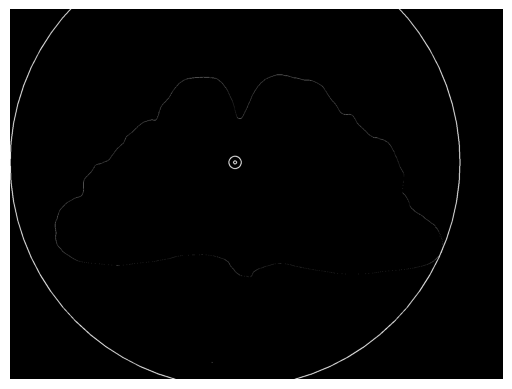

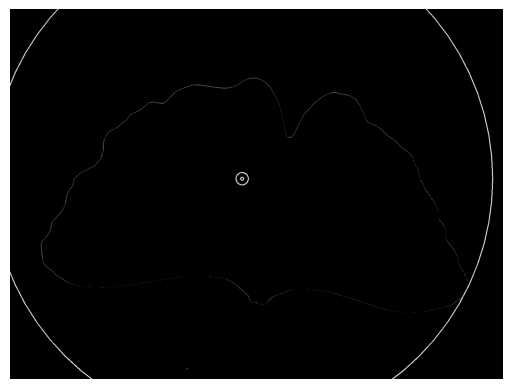

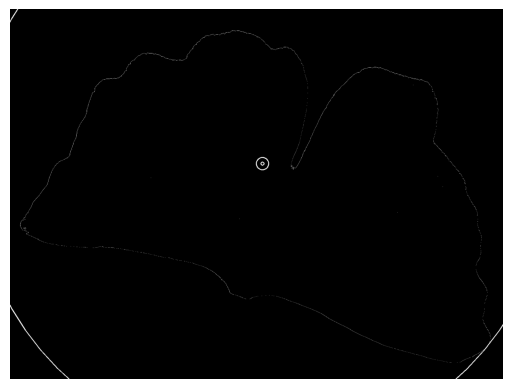

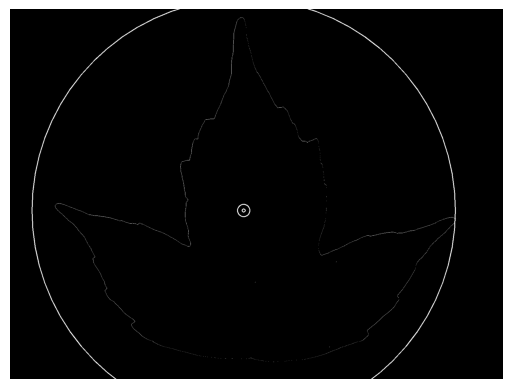

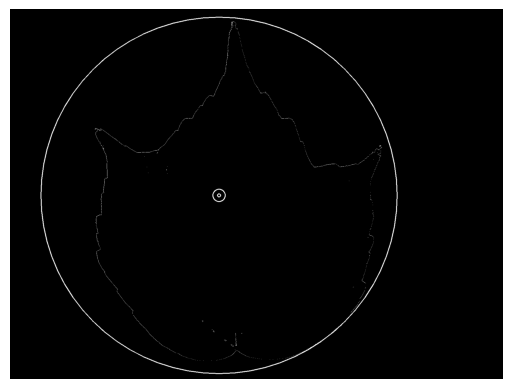

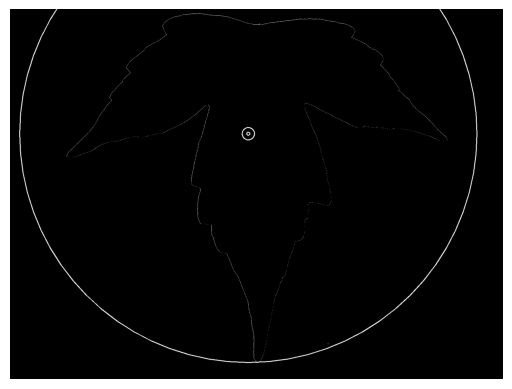

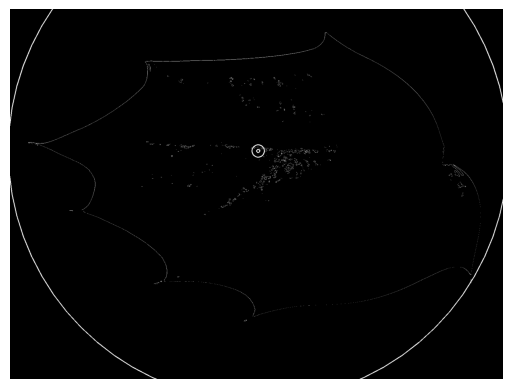

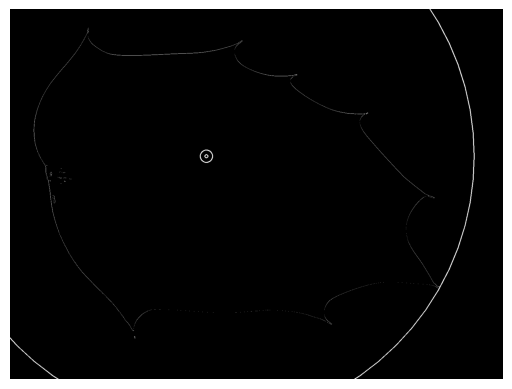

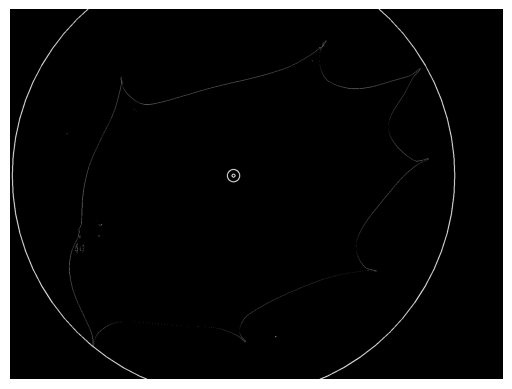

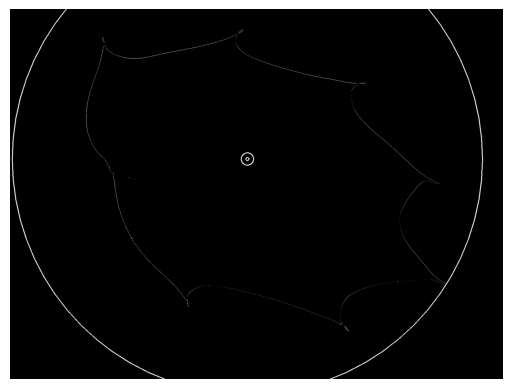

        Mean  centralmoment  standard_derivation  Maximum Radius  Eccentricity  Elongation       Surface  Estimated surface  Circularity            D  Form factor
1   0.893430     227.026267            15.067391      882.515888      0.536351    0.463649  8.954764e+05          89.547643     0.078476  1067.780876     0.986154
2   1.167023     296.228767            17.211298      807.642295      0.712565    0.287435  7.556598e+05          75.565985     0.142228   980.885314     1.787287
3   0.523148     133.129200            11.538163      944.136138      0.643461    0.356539  1.193878e+06         119.387825     0.073329  1232.920516     0.921473
4   0.653703     166.266883            12.894452      942.587234      0.682540    0.317460  1.225523e+06         122.552273     0.029476  1249.153313     0.370409
5   1.210586     307.233833            17.528087      842.084794      0.762427    0.237573  1.120625e+06         112.062495     0.016727  1194.497384     0.210200
6   1.545141     391.6

In [110]:
current_dir = os.getcwd()
path = os.path.join(current_dir, "images")

threshold = 200
df = process_images(path, threshold)
df.index = np.arange(1, len(df) + 1)
pd.set_option('display.expand_frame_repr', False)
print(df)


In [111]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df)
print(data_scaled)

[[-1.14996749e+00 -1.14937470e+00 -1.07870519e+00  1.12109785e+00
  -1.20523678e+00  1.20523678e+00 -2.33943734e-01 -2.33943734e-01
   1.36460907e+00 -1.60127039e-01  1.36460907e+00]
 [-4.72506461e-01 -4.70810977e-01 -3.65248296e-01  4.95647853e-01
  -2.15473930e-01  2.15473930e-01 -8.67929499e-01 -8.67929499e-01
   3.58389517e+00 -7.97456506e-01  3.58389517e+00]
 [-2.06684194e+00 -2.07008049e+00 -2.25317418e+00  1.63583721e+00
  -6.03616057e-01  6.03616057e-01  1.11913260e+00  1.11913260e+00
   1.18543213e+00  1.05107819e+00  1.18543213e+00]
 [-1.74356806e+00 -1.74514960e+00 -1.80182357e+00  1.62289857e+00
  -3.84118858e-01  3.84118858e-01  1.26262165e+00  1.26262165e+00
  -3.41118356e-01  1.17013651e+00 -3.41118356e-01]
 [-3.64638879e-01 -3.62901018e-01 -2.59826020e-01  7.83360248e-01
   6.45950918e-02 -6.45950918e-02  7.86972069e-01  7.86972069e-01
  -7.84925752e-01  7.69266387e-01 -7.84925752e-01]
 [ 4.63770995e-01  4.64579830e-01  4.92727908e-01 -8.78187962e-01
   1.03005162e+00 -

In [112]:
cov_matrix = np.cov(data_scaled, rowvar=False)
print (cov_matrix)

[[ 1.03225806  1.03225622  1.02705092 -0.86669474  0.37043396 -0.37043396
  -0.38784181 -0.38784181 -0.31090134 -0.35480973 -0.31090134]
 [ 1.03225622  1.03225806  1.02724179 -0.86714703  0.37006383 -0.37006383
  -0.38872079 -0.38872079 -0.31024789 -0.35565065 -0.31024789]
 [ 1.02705092  1.02724179  1.03225806 -0.88337589  0.34751619 -0.34751619
  -0.4307196  -0.4307196  -0.27401208 -0.39557546 -0.27401208]
 [-0.86669474 -0.86714703 -0.88337589  1.03225806 -0.29771211  0.29771211
   0.65262856  0.65262856  0.12856006  0.63151939  0.12856006]
 [ 0.37043396  0.37006383  0.34751619 -0.29771211  1.03225806 -1.03225806
   0.40583851  0.40583851  0.03505184  0.44752542  0.03505184]
 [-0.37043396 -0.37006383 -0.34751619  0.29771211 -1.03225806  1.03225806
  -0.40583851 -0.40583851 -0.03505184 -0.44752542 -0.03505184]
 [-0.38784181 -0.38872079 -0.4307196   0.65262856  0.40583851 -0.40583851
   1.03225806  1.03225806 -0.08486586  1.0290968  -0.08486586]
 [-0.38784181 -0.38872079 -0.4307196   0.

In [113]:
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

print(eigenvalues,eigenvectors)

[ 5.19325541e+00  3.49724119e+00  2.09225878e+00  4.74459445e-01
  9.09624722e-02  5.39248273e-03  1.26887305e-03  5.22995535e-08
  1.81652298e-17 -5.39556663e-17 -1.13861067e-16] [[ 3.98107883e-01  2.08342526e-01  5.14800427e-03 -3.39660622e-01
   1.37352757e-01  3.96035126e-01  1.28111296e-01 -7.00418133e-01
  -5.00791550e-10  6.55122270e-10 -4.51629034e-10]
 [ 3.98288957e-01  2.07936021e-01  4.74918927e-03 -3.39518874e-01
   1.36826339e-01  3.75054244e-01  1.19182957e-01  7.13611370e-01
   5.10213590e-10 -6.67438810e-10  4.60134213e-10]
 [ 4.05099478e-01  1.85827669e-01 -1.57291579e-02 -3.37932096e-01
   1.20215826e-01 -7.59990816e-01 -3.07743945e-01 -1.31438709e-02
  -9.38180478e-12  1.22636662e-11 -8.47581118e-12]
 [-4.16670370e-01 -6.54309401e-02  1.18063596e-01 -1.87436619e-01
   8.76125548e-01  1.09167150e-02 -7.29241606e-02  1.14328311e-04
   8.72216283e-14 -1.15004822e-13  7.09971654e-14]
 [ 4.54734633e-02  4.69981015e-01 -2.83724717e-01  4.04641252e-01
   1.79432330e-01  3.4

In [114]:

n_components = 2
projected_data = np.dot(data_scaled, eigenvectors[:, :n_components])
pc_columns = [f"PC{i}" for i in range(1, n_components + 1)]
pc_df = pd.DataFrame(data=projected_data, columns=pc_columns)
print(pc_df)


         PC1       PC2
0  -2.013892 -2.561990
1  -0.684630 -2.591112
2  -4.620295 -1.183779
3  -3.962400 -0.105324
4  -1.312404  0.901927
5   0.707127  1.264644
6   0.760492  1.208988
7   1.476219  0.863418
8   1.709220  1.154278
9   1.545287  2.499817
10  2.155294  2.897160
11  1.692000  2.408536
12  1.509803  1.142146
13  0.113937 -0.857716
14 -2.250375 -0.279256
15 -0.544090  1.592684
16  2.973455 -3.304260
17  2.816415 -3.310301
18  2.738929 -1.546577
19  2.433000 -4.529662
20  2.098218 -2.097247
21 -4.956927  0.303673
22  0.149581 -0.408631
23 -1.529063 -0.658542
24 -4.548875  0.003060
25 -0.133188  1.645864
26  2.618322  2.357815
27  0.213830  1.941733
28 -0.277803  0.534741
29 -2.016921 -0.170242
30  0.699488  0.603411
31  0.440247  0.280745


Text(0.5, 1.0, 'Projection of the data on the first 2 principal components')

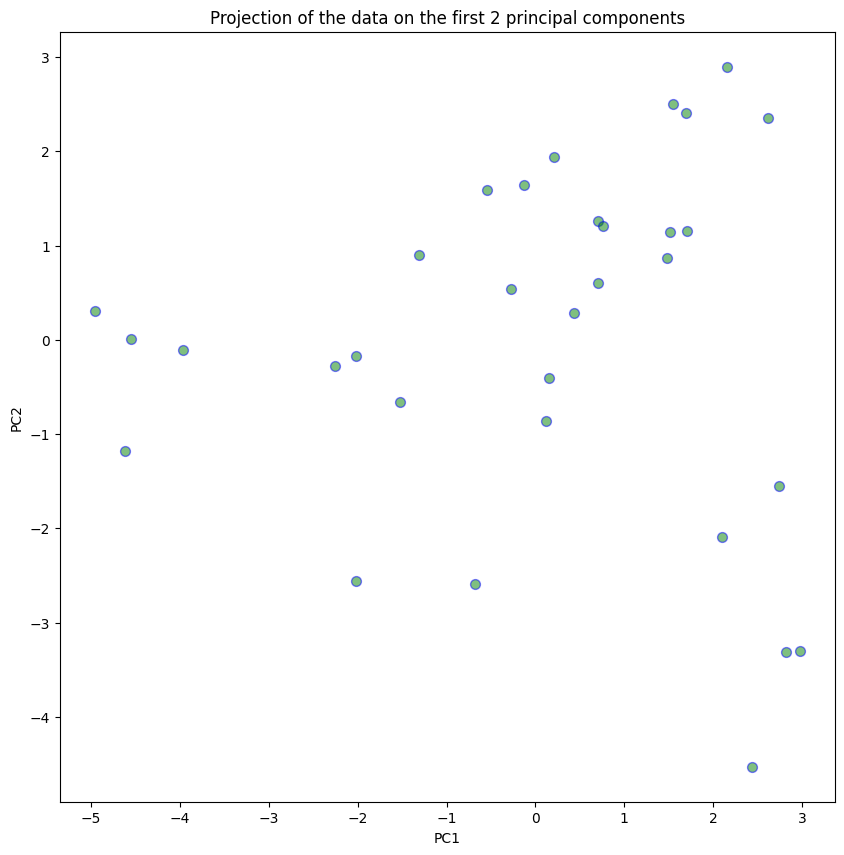

In [115]:
plt.figure(figsize=(10, 10))
plt.scatter(pc_df['PC1'], pc_df['PC2'], c='g', marker='o', edgecolors='b', s=50, alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Projection of the data on the first 2 principal components')

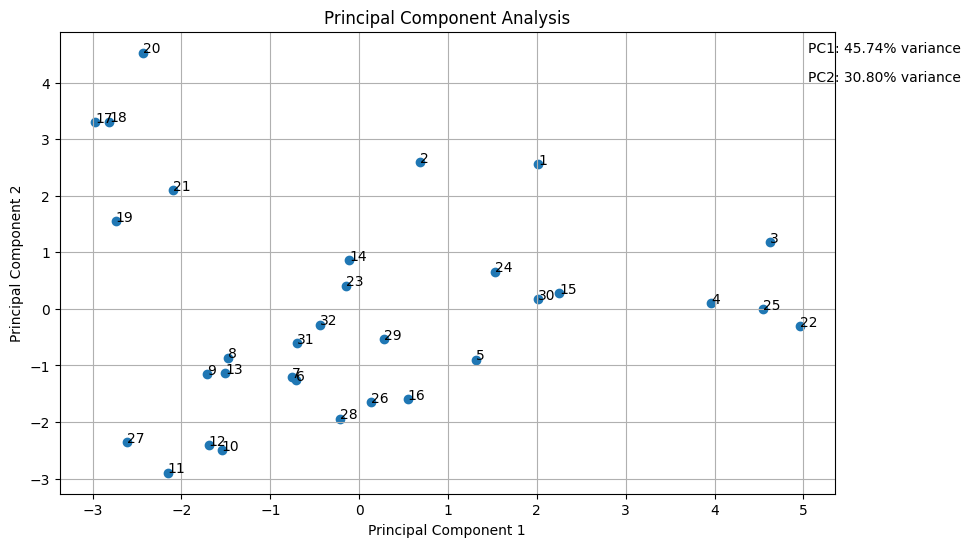

In [116]:
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
principal_components = pca.fit_transform(data_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1])

for i, txt in enumerate(df.index):
    plt.annotate(txt, (principal_components[i, 0], principal_components[i, 1]))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Principal Component Analysis')

for i in range(2):
    plt.text(principal_components[:, 0].max() + 0.1, principal_components[:, 1].max() - i * 0.5,
             f'PC{i+1}: {pca.explained_variance_ratio_[i]*100:.2f}% variance', fontsize=10)

plt.grid(True)
plt.show()
